## Desafío Cornershop

In [12]:
#Importar librerias necesarias para el desarrollo del desafio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from pycaret.regression import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
import gmaps
import os
import random
from geopy.distance import geodesic
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from datetime import *
import simplejson
import urllib

#Lectura de funciones pipeline Cornershop
import cornershop_functions.functions as corner_fx

#Magic commands
%matplotlib inline
%pylab inline
!jupyter nbextension enable --py --sys-prefix widgetsnbextension
!jupyter nbextension enable --py --sys-prefix gmaps

Populating the interactive namespace from numpy and matplotlib


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok
Enabling notebook extension jupyter-gmaps/extension...
      - Validating: ok


#### Lectura de bases

### File description and data fields
***order_products.csv:***
- order_id: ID of the order
- product_id: ID of the product
- quantity: The quantity ordered of this product
- buy_unit: The unit of the product (KG/UN)

***orders.csv:***
- order_id: ID of the order
- lat: The latitude of the delivery location
- lng: The longitude of the delivery location
- promised_time: The delivery time promised to the user
- on_demand: If true, the order was promised to be delivered in less than X minutes
- shopper_id: ID representing the shopper completed the order.
- store_branch_id: ID of the store branch
- total_minutes: The total minutes it took to complete the order (label)

***shopper.csv***
- shopper_id: ID of the shopper
- seniority: The experience level of the shopper.
- found_rate: Percentage of products found by shopper historical.
- picking_speed: Historical picking speed, products pr minutes.
- accepted_rate: Percentage of orders historically accepted by shopper
- rating: client rating of shopper

***storebranch.csv:***
- store_branch_id: ID of the store branch
- store: ID representing the store
- lat: Latitude of the branch location
- lng: Longitude of the branch location

- ***Proximos pasos***
    - Fillna en las bases donde se encuentren.
    - Generar Cluster por latitud y longitud
    - Generar features
    - Usar featuretools
    - Aplicar Pycaret (Quitar Outliers, Estandarizar, etc...)
    - Separar base de entrenamientos

    - Utilizar cantidad de items en total del pedido, cantidad en unidades y cantidad en Kg
    - Categoricas a numericas

    - Tipo de vehiculo, cuantos atrasos anteriormente ha tenido, hora del pedido,
    - Transito, clima, fecha del pedido, propina establecida, edad del shopper, ubicacion del pedido, trafico


In [2]:
#Lectura de base productos asociados a la orden
order_prod = corner_fx.read_dataset('./data/order_products.csv')
print('[INFO]... Mostrando las 5 primeras filas del dataset 🧐')
order_prod.head()


[INFO]... Leyendo csv con separador ";" 💾
[INFO]... Leyendo csv con otro separador 💾
[INFO]... Mostrando las 5 primeras filas del dataset 🧐


,order_id,product_id,quantity,buy_unit
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN


In [3]:
#Lectura de base de ordenes
orders = corner_fx.read_dataset('./data/orders.csv')
print('[INFO]... Mostrando las 5 primeras filas del dataset 🧐')
orders.head()

[INFO]... Leyendo csv con separador ";" 💾
[INFO]... Leyendo csv con otro separador 💾
[INFO]... Mostrando las 5 primeras filas del dataset 🧐


,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822


In [4]:
#Lectura de base de shoppers
shoppers = corner_fx.read_dataset('./data/shoppers.csv')
print('[INFO]... Mostrando las 5 primeras filas del dataset 🧐')
shoppers.head()

[INFO]... Leyendo csv con separador ";" 💾
[INFO]... Leyendo csv con otro separador 💾
[INFO]... Mostrando las 5 primeras filas del dataset 🧐


,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,NaN,2.41,NaN,NaN
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.8770,1.31,0.92,4.88


In [5]:
#Lectura de base de storebranch
stores = corner_fx.read_dataset('./data/storebranch.csv')
print('[INFO]... Mostrando las 5 primeras filas del dataset 🧐')
stores.head()

[INFO]... Leyendo csv con separador ";" 💾
[INFO]... Leyendo csv con otro separador 💾
[INFO]... Mostrando las 5 primeras filas del dataset 🧐


,store_branch_id,store_id,lat,lng
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224
3,2b24d495052a8ce66358eb576b8912c8,c4ca4238a0b923820dcc509a6f75849b,-33.512578,-70.655952
4,5487315b1286f907165907aa8fc96619,d82c8d1619ad8176d665453cfb2e55f0,-33.347645,-70.542229


### Estadisticos y información descriptiva de las bases

In [6]:
#Generando lista para obtener datos basicos
datasets = {'order_prod' : order_prod,
            'orders' : orders,
            'shoppers' : shoppers,
            'stores' : stores}

corner_fx.estadisticos(datasets)


[INFO]... Analizando base order_prod: 🔍 
 
[INFO]... Columnas del dataset: 👾

['order_id', 'product_id', 'quantity', 'buy_unit']

[INFO]... Cantidad de datos del dataset: 📉

Numero de columnas:  4

Numero de filas:  198500

[INFO]... Cantidad de datos nulos por columna: 🚫

order_id      0
product_id    0
quantity      0
buy_unit      0
dtype: int64

[INFO]... Tipos de variables: 🪴

order_id       object
product_id     object
quantity      float64
buy_unit       object
dtype: object

[INFO]... Estadisticos basicos: 🎯 
 
            quantity
count  198500.000000
mean        1.824126
std         1.905529
min         0.055000
25%         1.000000
50%         1.000000
75%         2.000000
max       100.000000

[INFO]... Analizando base orders: 🔍 
 
[INFO]... Columnas del dataset: 👾

['order_id', 'lat', 'lng', 'promised_time', 'on_demand', 'shopper_id', 'store_branch_id', 'total_minutes']

[INFO]... Cantidad de datos del dataset: 📉

Numero de columnas:  8

Numero de filas:  10000

[INFO]...

[INFO]... Utilizando API Gmaps para revisar ubicacion de las ordenes 🗺️


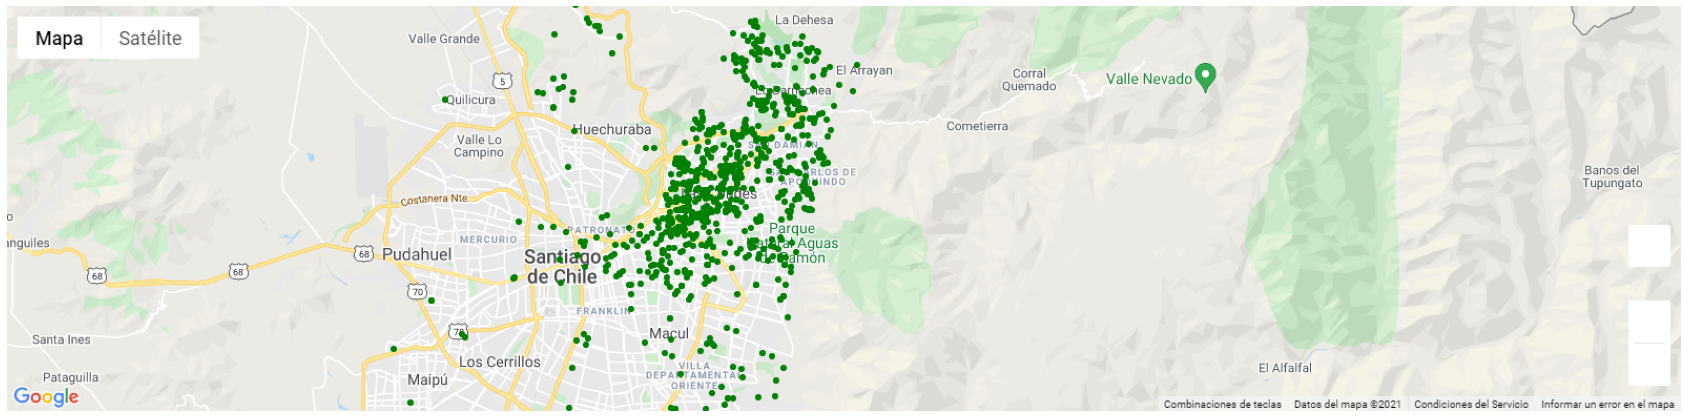

In [18]:
print('[INFO]... Utilizando API Gmaps para revisar ubicacion de las ordenes 🗺️')
order_maps = mpimg.imread('./data/map.png')
plt.figure(figsize = (30,15))
plt.imshow(order_maps)
plt.axis('off')
plt.show()

```python
print('[INFO]... Utilizando API Gmaps para revisar ubicacion de las ordenes 🗺️')
gmaps.configure(api_key="API_KEY")

#Creando listado con longitud y latitud
locations = pd.DataFrame([orders.lat, orders.lng])
locations = locations.T
locations = list(zip(orders['lat'],orders['lng']))

print('[INFO]... Seleccionando 1.000 registros aleatorios 🗺️')
random_points = []
for i in range(0,1000):
    n = random.randint(0,len(locations))
    random_points.append(locations[n])

print('Mapa:')
corner_trips = gmaps.symbol_layer(
                random_points, 
                fill_color="green", 
                stroke_color="green", 
                scale=2)
fig = gmaps.figure()
fig.add_layer(corner_trips)
fig
```

## Deep Feature Synthesis

### Order_products

[INFO]... Promedio de items por pedido [Kg]:  2


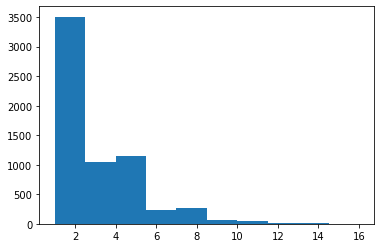

In [19]:
#Cuenta de productos solicitados por peso en cada pedido
kg_items = order_prod[order_prod['buy_unit']=='KG']['product_id'].groupby(order_prod['order_id']).agg(['count'])
print('[INFO]... Promedio de items por pedido [Kg]: ', int(kg_items.mean()))
plt.hist(kg_items)
plt.show()

[INFO]... Promedio de items por pedido [UN]:  18


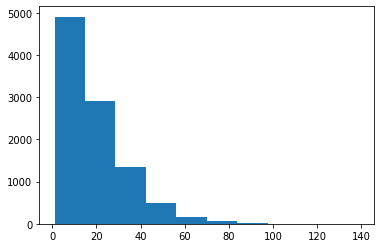

In [20]:
#Cantidad de items solicitados por Unidad en cada pedido
q_items = order_prod[order_prod['buy_unit']=='UN']['product_id'].groupby(order_prod['order_id']).agg(['count'])
print('[INFO]... Promedio de items por pedido [UN]: ', int(q_items.mean()))
plt.hist(q_items)
plt.show()

In [21]:
#Valores unicos en variables del dataset order_products
cols_list = ['product_id']
corner_fx.unique_values(order_prod, 20, cols_list)


[INFO] Frecuencia por dato unico para campo product_id 🚀...

Cantidad de valores unicos por categoría: 15422

Mostrando el top 20 categorias según frecuencia 
                                  Cantidad  Frecuencia  Frecuencia Acumulada
f90b55ea82b8af664f1d7eebb93f25e0      2073    1.044332              1.044332
bdcc4590896a0d0b419d0388fd16a859      1598    0.805038              1.849370
41da609c519d77b29be442f8c1105647      1562    0.786902              2.636272
280cf18baf4311c92aa5a042336587d3      1336    0.673048              3.309320
fb3336fca8851437f980e83045e75749      1092    0.550126              3.859446
42241c8a618f2d925c611ea9faaf44c4       876    0.441310              4.300756
f387d33f0f968f1005e9ef45b66266c6       836    0.421159              4.721914
deeb1b996407d124ff4ddf2f72a96ea0       818    0.412091              5.134005
03c3dafd39fe1c6abeb4bd72e3255d29       799    0.402519              5.536524
7e133b5ec7ad3911f79f03ebf0672200       790    0.397985              5.

### Order

In [22]:
#Valores unicos en variables dataset orders
col_list = ['on_demand','shopper_id','store_branch_id']
corner_fx.unique_values(orders, 20, col_list)


[INFO]
Frecuencia por dato unico para campo on_demand 🚀...
       Cantidad  Frecuencia  Frecuencia Acumulada
False      5453       54.53                 54.53
True       4547       45.47                100.00

[INFO] Frecuencia por dato unico para campo shopper_id 🚀...

Cantidad de valores unicos por categoría: 2864

Mostrando el top 20 categorias según frecuencia 
                                  Cantidad  Frecuencia  Frecuencia Acumulada
d0c2c143dce6d39eaec2c603f5242eea        14        0.14                  0.14
ef4e841d6962f1a51de44cba0edf87c3        13        0.13                  0.27
97475e20595a1db48dbc14e9b09e3822        13        0.13                  0.40
026251e438048d083f35ad11ab46e761        13        0.13                  0.53
bc0e4c734a6e9c3596e0dcf0bf8c657a        12        0.12                  0.65
4a7136775aaddcf343b33c08a8b91889        12        0.12                  0.77
e8d873c1a370459c3bd51579c3026863        12        0.12                  0.89
55c1f3382f7bf67

In [23]:
#Promedio de minutos que toma el pedido de acuerdo al store
print('[INFO]... Promedio del tiempo total que toma un pedido de acuerdo al store y shopper 📉')
store_time = orders['total_minutes'].groupby(orders['store_branch_id']).agg(['mean','count']).sort_values('count',ascending=False)
print(store_time[:10])
shopper_time = orders['total_minutes'].groupby(orders['shopper_id']).agg(['mean','count']).sort_values('count',ascending=False)
print(shopper_time[:10])

[INFO]... Promedio del tiempo total que toma un pedido de acuerdo al store y shopper 📉
                                        mean  count
store_branch_id                                    
1f0e3dad99908345f7439f8ffabdffc4   90.527534   1683
1679091c5a880faf6fb5e6087eb1b2dc   71.182551   1140
7ef605fc8dba5425d6965fbd4c8fbe1f   68.518737    549
c4ca4238a0b923820dcc509a6f75849b   70.495499    485
5751ec3e9a4feab575962e78e006250d  103.654176    453
45fbc6d3e05ebd93369ce542e8f2322d   87.124486    357
e4da3b7fbbce2345d7772b0674a318d5  103.711286    239
45c48cce2e2d7fbdea1afc51c7c6ad26   99.220115    151
3871bd64012152bfb53fdf04b401193f  117.387279    122
9461cce28ebe3e76fb4b931c35a169b0   93.170033    118
                                       mean  count
shopper_id                                        
c875f5839fecec41976b6f9ed3c44550  60.338546     12
e8d873c1a370459c3bd51579c3026863  61.309560     11
d0c2c143dce6d39eaec2c603f5242eea  53.362613     11
a7eb5509333af0c5f2520e84c873cff0  

[INFO]... Grafico del tiempo total que toma un pedido de acuerdo al shopper 🙋🏻‍♂️


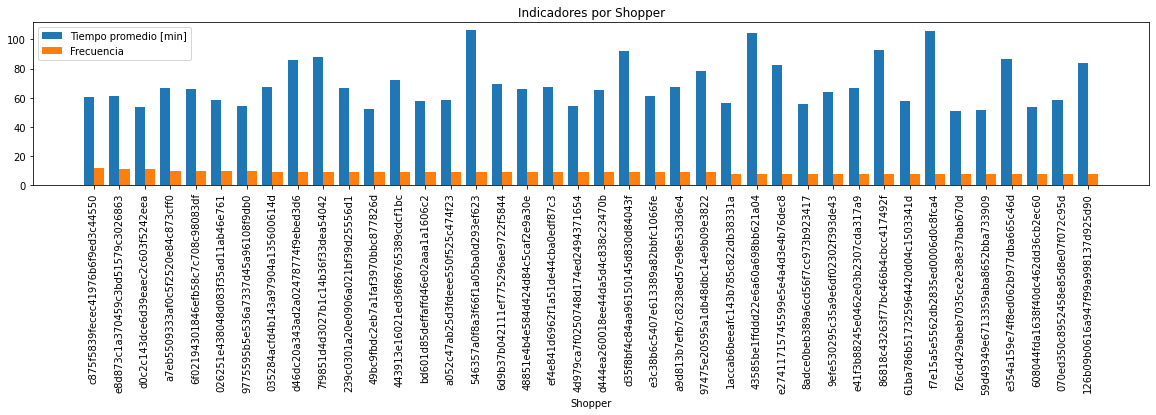

In [24]:
print('[INFO]... Grafico del tiempo total que toma un pedido de acuerdo al shopper 🙋🏻‍♂️')
q = 40
X = shopper_time.reset_index()['shopper_id'].values[:q]
Y = shopper_time.reset_index()['mean'].values[:q]
Z = shopper_time.reset_index()['count'].values[:q]
  
X_axis = np.arange(len(X))
plt.figure(figsize=(20,3)) 
plt.bar(X_axis - 0.2, Y, 0.4, label = 'Tiempo promedio [min]')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Frecuencia')

plt.xticks(X_axis, X, rotation=90)
plt.xlabel("Shopper")
plt.title("Indicadores por Shopper")
plt.legend()
plt.show()

[INFO]... Grafico del tiempo total que toma un pedido de acuerdo al store 🏪


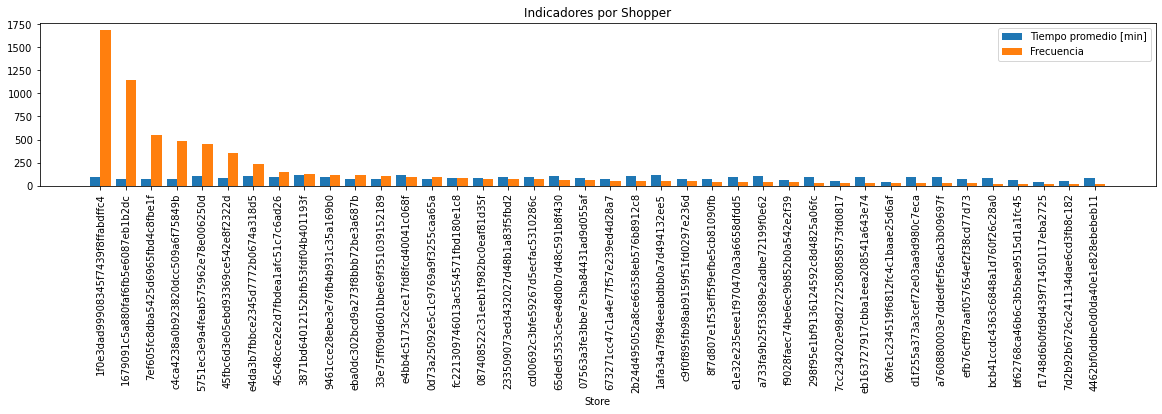

In [25]:
print('[INFO]... Grafico del tiempo total que toma un pedido de acuerdo al store 🏪')
q = 40
X = store_time.reset_index()['store_branch_id'].values[:q]
Y = store_time.reset_index()['mean'].values[:q]
Z = store_time.reset_index()['count'].values[:q]
  
X_axis = np.arange(len(X))
plt.figure(figsize=(20,3)) 
plt.bar(X_axis - 0.2, Y, 0.4, label = 'Tiempo promedio [min]')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Frecuencia')

plt.xticks(X_axis, X, rotation=90)
plt.xlabel("Store")
plt.title("Indicadores por Shopper")
plt.legend()
plt.show()

### Shoppers

In [26]:
#Datos unicos por variables en shoppers
col_list = ['shopper_id','seniority','rating', 'found_rate','picking_speed','accepted_rate']
corner_fx.unique_values(shoppers, 10, col_list)


[INFO] Frecuencia por dato unico para campo shopper_id 🚀...

Cantidad de valores unicos por categoría: 2864

Mostrando el top 10 categorias según frecuencia 
                                  Cantidad  Frecuencia  Frecuencia Acumulada
00056ea65bd3eae66762510a5b3baef0         1    0.034916              0.034916
ac454102e584e1c77dad2fec56f49d8e         1    0.034916              0.069832
aa72cfd0a626d5b718cfa202b11ecdb7         1    0.034916              0.104749
aa7f777e33f0f547d4028e199d054998         1    0.034916              0.139665
aa921ee664ee9a175ac7e35f8e602771         1    0.034916              0.174581
aaad45699a24c8a7308a76be032121ca         1    0.034916              0.209497
aab34f622ba13b9c6b823cdf377e942e         1    0.034916              0.244413
aac6df737e865e6cba7872533c4d311e         1    0.034916              0.279330
aadeeee9c2b0ed452b69a5819c39296a         1    0.034916              0.314246
ab2c5ac60944c1ffc65689bd642672eb         1    0.034916              0.3

In [27]:
print('[INFO]... Revisando dataset antes del cambio 🧐')
shoppers.head()

[INFO]... Revisando dataset antes del cambio 🧐


,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,NaN,2.41,NaN,NaN
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.8770,1.31,0.92,4.88


In [28]:
print('[INFO]... Completando datos vacios en shoppers 🎨')
#Promedio de indicadores por seniority para completar datos nulos en aquellos shoppers sin datos
indicators = shoppers[shoppers['rating'].isnull() == False].groupby(shoppers['seniority']).agg(['mean'])

#Loop para realizar fill na
for i in indicators.columns:
    x = str(i[0]) + str('_fillna')
    vars()[x] = pd.DataFrame(indicators[str(i[0])]['mean'].reset_index().rename(columns = {'mean' : str('mean_') + i[0] }))
    shoppers = pd.merge(shoppers, vars()[x], on = 'seniority', how = 'left')

    print('[INFO]... Completando datos vacios columna {}: 🎯'.format(x))
    shoppers[i[0]].fillna(shoppers[str('mean_') + str(i[0])], inplace = True)

    shoppers.drop(columns = (str('mean_') + str(i[0])), inplace = True)

print('[INFO]... Cantidad nulos: 🚫')
print(shoppers.isnull().sum())

print('[INFO]... Mostrando los 5 primeros registros de la base post tratamiento 🧐')
shoppers.head()


[INFO]... Completando datos vacios en shoppers 🎨
[INFO]... Completando datos vacios columna found_rate_fillna: 🎯
[INFO]... Completando datos vacios columna picking_speed_fillna: 🎯
[INFO]... Completando datos vacios columna accepted_rate_fillna: 🎯
[INFO]... Completando datos vacios columna rating_fillna: 🎯
[INFO]... Cantidad nulos: 🚫
shopper_id       0
seniority        0
found_rate       0
picking_speed    0
accepted_rate    0
rating           0
dtype: int64
[INFO]... Mostrando los 5 primeros registros de la base post tratamiento 🧐


,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.860600,1.94,1.00000,4.870000
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.844600,1.23,0.92000,4.920000
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.855900,1.56,1.00000,4.880000
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,0.846954,2.41,0.78644,4.843834
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.877000,1.31,0.92000,4.880000


### Creacion del dataset de entrenamiento

In [29]:
#Incorporando variables store a orders_df
orders = pd.merge(orders, stores, on = 'store_branch_id', how = 'left')
orders.head()

,order_id,lat_x,lng_x,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,store_id,lat_y,lng_y
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,c4ca4238a0b923820dcc509a6f75849b,-33.485280,-70.579250
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,c4ca4238a0b923820dcc509a6f75849b,-33.441246,-70.535450
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,f718499c1c8cef6730f9fd03c8125cab,-33.355258,-70.537787
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075


In [30]:
#Incorporando variables shoppers a orders_df
orders = pd.merge(orders, shoppers, on = 'shopper_id', how = 'left')
orders.head()

,order_id,lat_x,lng_x,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,store_id,lat_y,lng_y,seniority,found_rate,picking_speed,accepted_rate,rating
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,c4ca4238a0b923820dcc509a6f75849b,-33.485280,-70.579250,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,c4ca4238a0b923820dcc509a6f75849b,-33.441246,-70.535450,41dc7c9e385c4d2b6c1f7836973951bf,0.7610,2.54,0.92,4.96
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,f718499c1c8cef6730f9fd03c8125cab,-33.355258,-70.537787,41dc7c9e385c4d2b6c1f7836973951bf,0.8776,2.80,0.96,4.76
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075,50e13ee63f086c2fe84229348bc91b5b,0.7838,2.40,0.96,4.96


In [31]:
#Incorporando variables productos a orders_df
orders = pd.merge(orders, q_items.reset_index().rename(columns = {'count' : 'q_unit'}), on = 'order_id', how = 'left')
orders['q_unit'].fillna(0, inplace = True)
orders = pd.merge(orders, kg_items.reset_index().rename(columns = {'count' : 'kg_unit'}), on = 'order_id', how = 'left')
orders['kg_unit'].fillna(0, inplace = True)
orders.head()

,order_id,lat_x,lng_x,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,store_id,lat_y,lng_y,seniority,found_rate,picking_speed,accepted_rate,rating,q_unit,kg_unit
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,c4ca4238a0b923820dcc509a6f75849b,-33.485280,-70.579250,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,15.0,4.0
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,c4ca4238a0b923820dcc509a6f75849b,-33.441246,-70.535450,41dc7c9e385c4d2b6c1f7836973951bf,0.7610,2.54,0.92,4.96,5.0,0.0
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,5.0,0.0
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,f718499c1c8cef6730f9fd03c8125cab,-33.355258,-70.537787,41dc7c9e385c4d2b6c1f7836973951bf,0.8776,2.80,0.96,4.76,1.0,0.0
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075,50e13ee63f086c2fe84229348bc91b5b,0.7838,2.40,0.96,4.96,46.0,5.0


In [32]:
#Creacion de variable distancia entre direccion del pedido y direccion del store
orders['distancia'] = [geodesic((orders['lat_x'][x], orders['lng_x'][x]), (orders['lat_y'][x], orders['lng_y'][x])).km for x in range(orders.shape[0])]
orders.head()

,order_id,lat_x,lng_x,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,store_id,lat_y,lng_y,seniority,found_rate,picking_speed,accepted_rate,rating,q_unit,kg_unit,distancia
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,c4ca4238a0b923820dcc509a6f75849b,-33.485280,-70.579250,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,15.0,4.0,1.818407
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,c4ca4238a0b923820dcc509a6f75849b,-33.441246,-70.535450,41dc7c9e385c4d2b6c1f7836973951bf,0.7610,2.54,0.92,4.96,5.0,0.0,1.938544
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,5.0,0.0,2.351240
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,f718499c1c8cef6730f9fd03c8125cab,-33.355258,-70.537787,41dc7c9e385c4d2b6c1f7836973951bf,0.8776,2.80,0.96,4.76,1.0,0.0,3.815982
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075,50e13ee63f086c2fe84229348bc91b5b,0.7838,2.40,0.96,4.96,46.0,5.0,1.889404


In [33]:
#Generando variable con dia, mes y año del pedido **Para efectos de calculo, se usara promised_time dado que no se tiene campo con fecha de origen del pedido.
orders['dia_pedido'] = [pd.to_datetime(orders['promised_time'][x]).day for x in range(orders.shape[0])]
orders['mes_pedido'] = [pd.to_datetime(orders['promised_time'][x]).month for x in range(orders.shape[0])]
orders['año_pedido'] = [pd.to_datetime(orders['promised_time'][x]).year for x in range(orders.shape[0])]
orders.head()

,order_id,lat_x,lng_x,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,store_id,lat_y,lng_y,seniority,found_rate,picking_speed,accepted_rate,rating,q_unit,kg_unit,distancia,dia_pedido,mes_pedido,año_pedido
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,c4ca4238a0b923820dcc509a6f75849b,-33.485280,-70.579250,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,15.0,4.0,1.818407,18,10,2019
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,c4ca4238a0b923820dcc509a6f75849b,-33.441246,-70.535450,41dc7c9e385c4d2b6c1f7836973951bf,0.7610,2.54,0.92,4.96,5.0,0.0,1.938544,19,10,2019
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,5.0,0.0,2.351240,19,10,2019
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,f718499c1c8cef6730f9fd03c8125cab,-33.355258,-70.537787,41dc7c9e385c4d2b6c1f7836973951bf,0.8776,2.80,0.96,4.76,1.0,0.0,3.815982,18,10,2019
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075,50e13ee63f086c2fe84229348bc91b5b,0.7838,2.40,0.96,4.96,46.0,5.0,1.889404,19,10,2019


In [34]:
#Generando variable con hora del pedido **Para efectos de calculo, se usara promised_time dado que no se tiene campo con fecha de origen del pedido.
orders['hora_pedido'] = [pd.to_datetime(orders['promised_time'][x]).hour for x in range(orders.shape[0])]
orders['minute_pedido'] = [pd.to_datetime(orders['promised_time'][x]).minute for x in range(orders.shape[0])]
orders.head()

,order_id,lat_x,lng_x,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,store_id,lat_y,lng_y,seniority,found_rate,picking_speed,accepted_rate,rating,q_unit,kg_unit,distancia,dia_pedido,mes_pedido,año_pedido,hora_pedido,minute_pedido
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,c4ca4238a0b923820dcc509a6f75849b,-33.485280,-70.579250,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,15.0,4.0,1.818407,18,10,2019,20,48
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,c4ca4238a0b923820dcc509a6f75849b,-33.441246,-70.535450,41dc7c9e385c4d2b6c1f7836973951bf,0.7610,2.54,0.92,4.96,5.0,0.0,1.938544,19,10,2019,1,0
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,5.0,0.0,2.351240,19,10,2019,14,54
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,f718499c1c8cef6730f9fd03c8125cab,-33.355258,-70.537787,41dc7c9e385c4d2b6c1f7836973951bf,0.8776,2.80,0.96,4.76,1.0,0.0,3.815982,18,10,2019,21,47
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075,50e13ee63f086c2fe84229348bc91b5b,0.7838,2.40,0.96,4.96,46.0,5.0,1.889404,19,10,2019,20,0


```python
#Obteniendo trafico en tiempo real de acuerdo a fecha **Dada que la API funciona en tiempo futuro no es posible calcular para cada fecha en particular (generar un cierto sesgo pero es una variable clave en la optimizacion)
print('[INFO]... Obteniendo distancia y duracion de viaje segun fecha y hora en API Google Maps 🗺️')
results = []
for i in range(orders_df.shape[0]):
    orig_coord = str(np.round(orders_df['lat_x'][i],6)) + '%2C' + str(np.round(orders_df['lng_x'][i],6))
    dest_coord = str(np.round(orders_df['lat_y'][i],6)) + '%2C' + str(np.round(orders_df['lng_y'][i],6))
    url = "https://maps.googleapis.com/maps/api/distancematrix/json?departure_time=now&origins={0}&destinations={1}&mode=driving&language=es-ES&sensor=false&units=metric&key=API_KEY".format(str(orig_coord),str(dest_coord))
    url = url.replace(" ","")
    result= simplejson.load(urllib.request.urlopen(url))
    driving_time = result['rows'][0]['elements'][0]['duration_in_traffic']['value']
    distance = float(result['rows'][0]['elements'][0]['distance']['text'][0:3].replace(" ","").replace(",","."))
    results.append((driving_time,distance))
 ```

```python
#Creando dataframe para concatenar a orders_df
maps_results = pd.DataFrame(results).rename(columns={0 : 'trip_second', 1: 'km_distance_trip'})
maps_results.head()
```

In [37]:
#Leyendo dataset generado por funcion anterior (comentada para no consumir nuevamente API)
maps_results = corner_fx.read_dataset('./data/maps_results.csv')
maps_results.drop(columns = ('Unnamed: 0'), inplace = True)
maps_results.head()

[INFO]... Leyendo csv con separador ";" 💾
[INFO]... Leyendo csv con otro separador 💾


,trip_second,km_distance_trip
0,475,2.6
1,606,3.1
2,529,3.3
3,572,5.2
4,542,3.3


In [38]:
#Concatenando dataframes
orders = pd.concat([orders.reset_index(drop=True), maps_results], axis = 1).set_index('order_id')
orders.head()

,lat_x,lng_x,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,store_id,lat_y,lng_y,seniority,found_rate,picking_speed,accepted_rate,rating,q_unit,kg_unit,distancia,dia_pedido,mes_pedido,año_pedido,hora_pedido,minute_pedido,trip_second,km_distance_trip
order_id,,,,,,,,,,,,,,,,,,,,,,,,,
e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,c4ca4238a0b923820dcc509a6f75849b,-33.485280,-70.579250,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,15.0,4.0,1.818407,18,10,2019,20,48,475,2.6
6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,c4ca4238a0b923820dcc509a6f75849b,-33.441246,-70.535450,41dc7c9e385c4d2b6c1f7836973951bf,0.7610,2.54,0.92,4.96,5.0,0.0,1.938544,19,10,2019,1,0,606,3.1
3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,5.0,0.0,2.351240,19,10,2019,14,54,529,3.3
7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,f718499c1c8cef6730f9fd03c8125cab,-33.355258,-70.537787,41dc7c9e385c4d2b6c1f7836973951bf,0.8776,2.80,0.96,4.76,1.0,0.0,3.815982,18,10,2019,21,47,572,5.2
b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075,50e13ee63f086c2fe84229348bc91b5b,0.7838,2.40,0.96,4.96,46.0,5.0,1.889404,19,10,2019,20,0,542,3.3


In [39]:
#Concatenando tiempo promedio por store y shoppers
orders = pd.merge(orders.reset_index(),  store_time.reset_index()[['store_branch_id','mean']], on = 'store_branch_id', how = 'left')
orders.rename(columns={'mean':'avg_time_stores'}, inplace = True)
orders.head()

,order_id,lat_x,lng_x,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,store_id,lat_y,lng_y,seniority,found_rate,picking_speed,accepted_rate,rating,q_unit,kg_unit,distancia,dia_pedido,mes_pedido,año_pedido,hora_pedido,minute_pedido,trip_second,km_distance_trip,avg_time_stores
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,c4ca4238a0b923820dcc509a6f75849b,-33.485280,-70.579250,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,15.0,4.0,1.818407,18,10,2019,20,48,475,2.6,100.792544
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,c4ca4238a0b923820dcc509a6f75849b,-33.441246,-70.535450,41dc7c9e385c4d2b6c1f7836973951bf,0.7610,2.54,0.92,4.96,5.0,0.0,1.938544,19,10,2019,1,0,606,3.1,87.124486
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,5.0,0.0,2.351240,19,10,2019,14,54,529,3.3,86.012776
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,f718499c1c8cef6730f9fd03c8125cab,-33.355258,-70.537787,41dc7c9e385c4d2b6c1f7836973951bf,0.8776,2.80,0.96,4.76,1.0,0.0,3.815982,18,10,2019,21,47,572,5.2,44.164662
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075,50e13ee63f086c2fe84229348bc91b5b,0.7838,2.40,0.96,4.96,46.0,5.0,1.889404,19,10,2019,20,0,542,3.3,90.527534


In [40]:
#Concatenando tiempo promedio por store y shoppers
orders = pd.merge(orders,  shopper_time.reset_index()[['shopper_id','mean']], on = 'shopper_id', how = 'left')
#renombrando columna mean shopper
orders.rename(columns={'mean':'avg_time_shopper'}, inplace = True)
orders.head()

,order_id,lat_x,lng_x,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,store_id,lat_y,lng_y,seniority,found_rate,picking_speed,accepted_rate,rating,q_unit,kg_unit,distancia,dia_pedido,mes_pedido,año_pedido,hora_pedido,minute_pedido,trip_second,km_distance_trip,avg_time_stores,avg_time_shopper
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,c4ca4238a0b923820dcc509a6f75849b,-33.485280,-70.579250,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,15.0,4.0,1.818407,18,10,2019,20,48,475,2.6,100.792544,114.010237
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,c4ca4238a0b923820dcc509a6f75849b,-33.441246,-70.535450,41dc7c9e385c4d2b6c1f7836973951bf,0.7610,2.54,0.92,4.96,5.0,0.0,1.938544,19,10,2019,1,0,606,3.1,87.124486,70.236804
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,c4ca4238a0b923820dcc509a6f75849b,-33.008213,-71.545615,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,5.0,0.0,2.351240,19,10,2019,14,54,529,3.3,86.012776,92.827710
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,f718499c1c8cef6730f9fd03c8125cab,-33.355258,-70.537787,41dc7c9e385c4d2b6c1f7836973951bf,0.8776,2.80,0.96,4.76,1.0,0.0,3.815982,18,10,2019,21,47,572,5.2,44.164662,58.891954
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,c4ca4238a0b923820dcc509a6f75849b,-33.386547,-70.568075,50e13ee63f086c2fe84229348bc91b5b,0.7838,2.40,0.96,4.96,46.0,5.0,1.889404,19,10,2019,20,0,542,3.3,90.527534,86.807626


In [41]:
#Columnas del dataset
orders.set_index('order_id', inplace = True)
orders.columns

Index(['lat_x', 'lng_x', 'promised_time', 'on_demand', 'shopper_id',
       'store_branch_id', 'total_minutes', 'store_id', 'lat_y', 'lng_y',
       'seniority', 'found_rate', 'picking_speed', 'accepted_rate', 'rating',
       'q_unit', 'kg_unit', 'distancia', 'dia_pedido', 'mes_pedido',
       'año_pedido', 'hora_pedido', 'minute_pedido', 'trip_second',
       'km_distance_trip', 'avg_time_stores', 'avg_time_shopper'],
      dtype='object')

In [42]:
#dataset final
cols = ['lat_x', 'lng_x', 'on_demand', 'shopper_id', 'store_branch_id', 'total_minutes', 'store_id',
        'seniority', 'found_rate', 'picking_speed', 'accepted_rate', 'rating', 'q_unit', 'kg_unit', 'distancia',
        'dia_pedido', 'mes_pedido', 'año_pedido', 'hora_pedido', 'minute_pedido', 'lat_y', 'lng_y', 'trip_second',
        'km_distance_trip', 'avg_time_stores', 'avg_time_shopper']
df = orders[cols]
df.head()

,lat_x,lng_x,on_demand,shopper_id,store_branch_id,total_minutes,store_id,seniority,found_rate,picking_speed,accepted_rate,rating,q_unit,kg_unit,distancia,dia_pedido,mes_pedido,año_pedido,hora_pedido,minute_pedido,lat_y,lng_y,trip_second,km_distance_trip,avg_time_stores,avg_time_shopper
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,
e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,c4ca4238a0b923820dcc509a6f75849b,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,15.0,4.0,1.818407,18,10,2019,20,48,-33.485280,-70.579250,475,2.6,100.792544,114.010237
6581174846221cb6c467348e87f57641,-33.440584,-70.556283,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,c4ca4238a0b923820dcc509a6f75849b,41dc7c9e385c4d2b6c1f7836973951bf,0.7610,2.54,0.92,4.96,5.0,0.0,1.938544,19,10,2019,1,0,-33.441246,-70.535450,606,3.1,87.124486,70.236804
3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,c4ca4238a0b923820dcc509a6f75849b,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,5.0,0.0,2.351240,19,10,2019,14,54,-33.008213,-71.545615,529,3.3,86.012776,92.827710
7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,f718499c1c8cef6730f9fd03c8125cab,41dc7c9e385c4d2b6c1f7836973951bf,0.8776,2.80,0.96,4.76,1.0,0.0,3.815982,18,10,2019,21,47,-33.355258,-70.537787,572,5.2,44.164662,58.891954
b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,c4ca4238a0b923820dcc509a6f75849b,50e13ee63f086c2fe84229348bc91b5b,0.7838,2.40,0.96,4.96,46.0,5.0,1.889404,19,10,2019,20,0,-33.386547,-70.568075,542,3.3,90.527534,86.807626


In [43]:
#Convertir on demand en categorica para conversion
df['on_demand'] = df['on_demand'].astype('object')
df.head()

,lat_x,lng_x,on_demand,shopper_id,store_branch_id,total_minutes,store_id,seniority,found_rate,picking_speed,accepted_rate,rating,q_unit,kg_unit,distancia,dia_pedido,mes_pedido,año_pedido,hora_pedido,minute_pedido,lat_y,lng_y,trip_second,km_distance_trip,avg_time_stores,avg_time_shopper
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,
e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,c4ca4238a0b923820dcc509a6f75849b,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,15.0,4.0,1.818407,18,10,2019,20,48,-33.485280,-70.579250,475,2.6,100.792544,114.010237
6581174846221cb6c467348e87f57641,-33.440584,-70.556283,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,c4ca4238a0b923820dcc509a6f75849b,41dc7c9e385c4d2b6c1f7836973951bf,0.7610,2.54,0.92,4.96,5.0,0.0,1.938544,19,10,2019,1,0,-33.441246,-70.535450,606,3.1,87.124486,70.236804
3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,c4ca4238a0b923820dcc509a6f75849b,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,5.0,0.0,2.351240,19,10,2019,14,54,-33.008213,-71.545615,529,3.3,86.012776,92.827710
7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,f718499c1c8cef6730f9fd03c8125cab,41dc7c9e385c4d2b6c1f7836973951bf,0.8776,2.80,0.96,4.76,1.0,0.0,3.815982,18,10,2019,21,47,-33.355258,-70.537787,572,5.2,44.164662,58.891954
b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,c4ca4238a0b923820dcc509a6f75849b,50e13ee63f086c2fe84229348bc91b5b,0.7838,2.40,0.96,4.96,46.0,5.0,1.889404,19,10,2019,20,0,-33.386547,-70.568075,542,3.3,90.527534,86.807626


In [44]:
#Datos unicos por variables dataframe
corner_fx.unique_values(df, 10, cols)


[INFO] Frecuencia por dato unico para campo lat_x 🚀...

Cantidad de valores unicos por categoría: 8241

Mostrando el top 10 categorias según frecuencia 
            Cantidad  Frecuencia  Frecuencia Acumulada
-33.368572        10        0.10                  0.10
-33.389740         7        0.07                  0.17
-33.422240         7        0.07                  0.24
-33.371973         7        0.07                  0.31
-33.369648         6        0.06                  0.37
-33.371888         6        0.06                  0.43
-33.403923         6        0.06                  0.49
-33.326007         6        0.06                  0.55
-33.387828         6        0.06                  0.61
-33.332739         6        0.06                  0.67

[INFO] Frecuencia por dato unico para campo lng_x 🚀...

Cantidad de valores unicos por categoría: 8193

Mostrando el top 10 categorias según frecuencia 
            Cantidad  Frecuencia  Frecuencia Acumulada
-70.627804         8        0.08

In [45]:
#Revisando tipos de columns
df.dtypes

lat_x               float64
lng_x               float64
on_demand            object
shopper_id           object
store_branch_id      object
total_minutes       float64
store_id             object
seniority            object
found_rate          float64
picking_speed       float64
accepted_rate       float64
rating              float64
q_unit              float64
kg_unit             float64
distancia           float64
dia_pedido            int64
mes_pedido            int64
año_pedido            int64
hora_pedido           int64
minute_pedido         int64
lat_y               float64
lng_y               float64
trip_second           int64
km_distance_trip    float64
avg_time_stores     float64
avg_time_shopper    float64
dtype: object

In [46]:
#Convertir variables categoricas
df_out = corner_fx.cat_encoding(df)
df_out.head()


[INFO] Transformando variables... 🚀
[INFO] Seleccionando variables... ✅

[INFO] Dataset final: ... 🛫



,lat_x,lng_x,on_demand,shopper_id,store_branch_id,total_minutes,store_id,seniority,found_rate,picking_speed,accepted_rate,rating,q_unit,kg_unit,distancia,dia_pedido,mes_pedido,año_pedido,hora_pedido,minute_pedido,lat_y,lng_y,trip_second,km_distance_trip,avg_time_stores,avg_time_shopper,on_demand_cat,shopper_id_cat,store_branch_id_cat,store_id_cat,seniority_cat
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,c4ca4238a0b923820dcc509a6f75849b,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,15.0,4.0,1.818407,18,10,2019,20,48,-33.485280,-70.579250,475,2.6,100.792544,114.010237,1,2573,181,163,2
6581174846221cb6c467348e87f57641,-33.440584,-70.556283,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,c4ca4238a0b923820dcc509a6f75849b,41dc7c9e385c4d2b6c1f7836973951bf,0.7610,2.54,0.92,4.96,5.0,0.0,1.938544,19,10,2019,1,0,-33.441246,-70.535450,606,3.1,87.124486,70.236804,0,292,130,163,0
3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,c4ca4238a0b923820dcc509a6f75849b,50e13ee63f086c2fe84229348bc91b5b,0.8313,2.57,0.76,4.92,5.0,0.0,2.351240,19,10,2019,14,54,-33.008213,-71.545615,529,3.3,86.012776,92.827710,1,1855,20,163,1
7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,f718499c1c8cef6730f9fd03c8125cab,41dc7c9e385c4d2b6c1f7836973951bf,0.8776,2.80,0.96,4.76,1.0,0.0,3.815982,18,10,2019,21,47,-33.355258,-70.537787,572,5.2,44.164662,58.891954,1,2302,445,213,0
b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,c4ca4238a0b923820dcc509a6f75849b,50e13ee63f086c2fe84229348bc91b5b,0.7838,2.40,0.96,4.96,46.0,5.0,1.889404,19,10,2019,20,0,-33.386547,-70.568075,542,3.3,90.527534,86.807626,0,1033,58,163,1


In [47]:
df_out.drop(columns = ['on_demand', 'shopper_id', 'store_branch_id', 'store_id', 'seniority'], inplace = True)
df_out.head()

,lat_x,lng_x,total_minutes,found_rate,picking_speed,accepted_rate,rating,q_unit,kg_unit,distancia,dia_pedido,mes_pedido,año_pedido,hora_pedido,minute_pedido,lat_y,lng_y,trip_second,km_distance_trip,avg_time_stores,avg_time_shopper,on_demand_cat,shopper_id_cat,store_branch_id_cat,store_id_cat,seniority_cat
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,
e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,67.684264,0.9024,1.30,0.92,4.76,15.0,4.0,1.818407,18,10,2019,20,48,-33.485280,-70.579250,475,2.6,100.792544,114.010237,1,2573,181,163,2
6581174846221cb6c467348e87f57641,-33.440584,-70.556283,57.060632,0.7610,2.54,0.92,4.96,5.0,0.0,1.938544,19,10,2019,1,0,-33.441246,-70.535450,606,3.1,87.124486,70.236804,0,292,130,163,0
3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,NaN,0.8313,2.57,0.76,4.92,5.0,0.0,2.351240,19,10,2019,14,54,-33.008213,-71.545615,529,3.3,86.012776,92.827710,1,1855,20,163,1
7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,52.067742,0.8776,2.80,0.96,4.76,1.0,0.0,3.815982,18,10,2019,21,47,-33.355258,-70.537787,572,5.2,44.164662,58.891954,1,2302,445,213,0
b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,140.724822,0.7838,2.40,0.96,4.96,46.0,5.0,1.889404,19,10,2019,20,0,-33.386547,-70.568075,542,3.3,90.527534,86.807626,0,1033,58,163,1


In [48]:
#Seleccionando columnas tipo float e int para correlacion
cols = df_out.select_dtypes(include=['float','int']).columns.to_list()
cols.remove('lat_x')
cols.remove('lng_x')
cols.remove('lat_y')
cols.remove('lng_y')

[INFO] Generando grafico de correlacion... 🚀



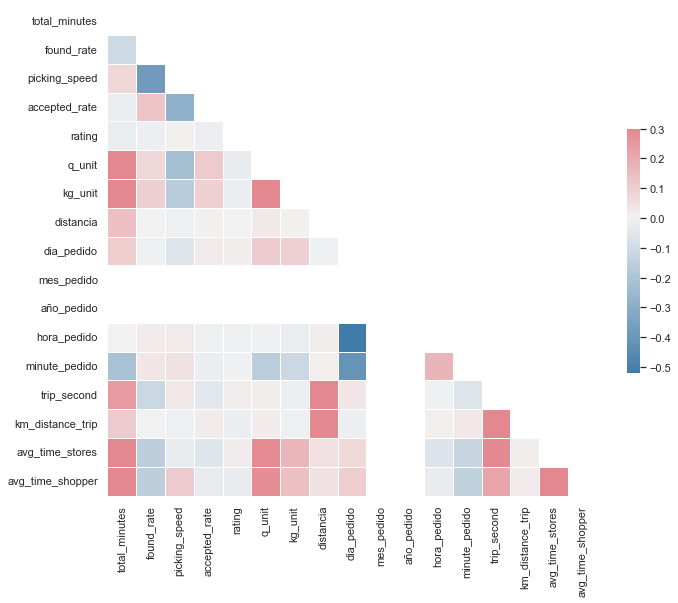

In [49]:
#Correlacion entre variables
corner_fx.correlation(df_out[cols])

[INFO] Revisando outliers en campos tipo numericos... 🔍



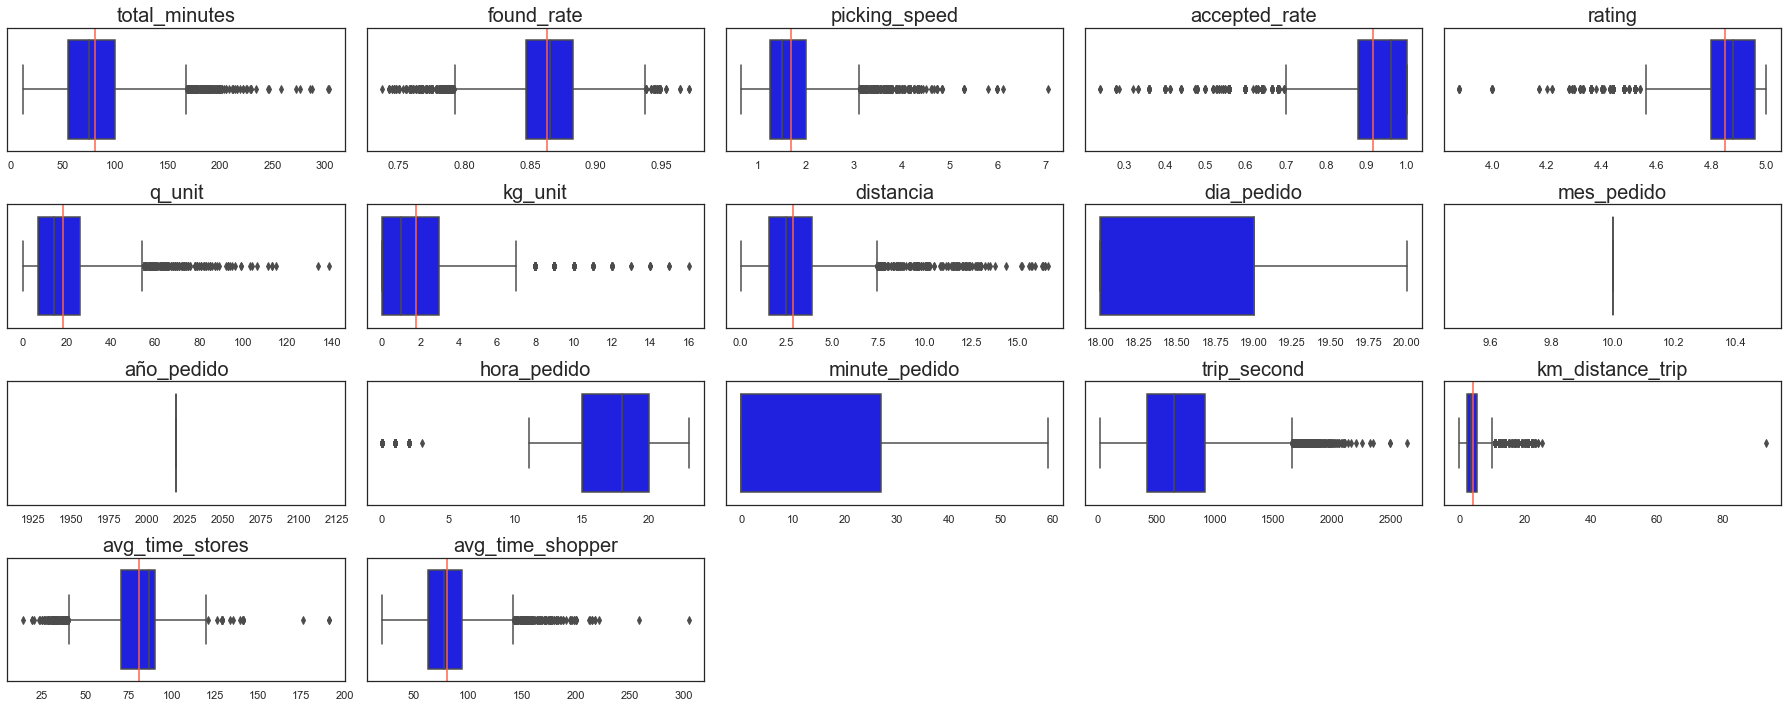

In [50]:
#Revisando outliers en variables
corner_fx.plot_boxplot(df_out, 5, cols)

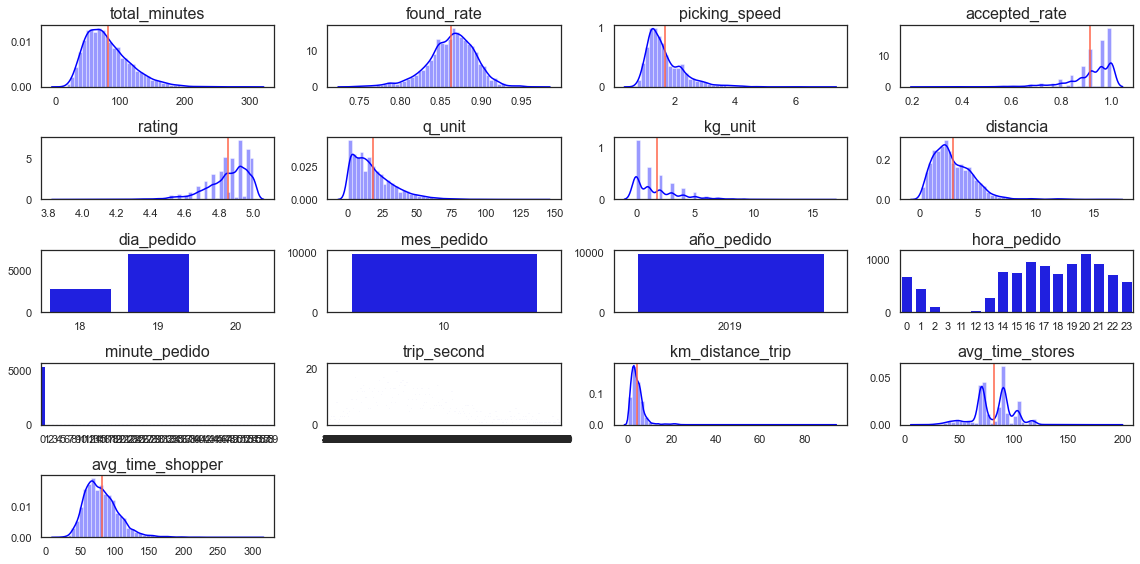

In [51]:
#Histogramas para revisión de distribucion
corner_fx.plot_hist_frec(df_out[cols], 4)

### Estimando regresion lineal por minimos cuadrados ordinarios total_minutes ~ (variables correlacionadas positivamente) 

In [57]:
#Regresion lineal
x = df_out[df_out['total_minutes'].isnull() == False] #Dejar dataset entregable fuera
X = x[['trip_second','found_rate', 'q_unit', 'kg_unit','distancia','avg_time_stores','avg_time_shopper']]
y = x['total_minutes']

In [58]:
#Separacion del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle = True, random_state = 42)

In [59]:
#Shape
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6400, 7) (6400,)
(1600, 7) (1600,)


In [60]:
#Entrenamiento del modelo
model = sm.OLS(y_train, X_train).fit()
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          total_minutes   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                          1.656e+04
Date:                Fri, 10 Sep 2021   Prob (F-statistic):                        0.00
Time:                        09:14:31   Log-Likelihood:                         -28316.
No. Observations:                6400   AIC:                                  5.665e+04
Df Residuals:                    6393   BIC:                                  5.669e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
trip_second          0.0014      0.001      1.255      0.210      -0.001       0.004
found_rate         -26.7981      1.434    -18.689      0.000     -29.609     -23.987
q_unit               0.7588      0.020     37.329      0.000       0.719       0.799
kg_unit              1.0980      0.141      7.786      0.000       0.822       1.374
distancia            1.6422      0.212      7.748      0.000       1.227       2.058
avg_time_stores      0.3191      0.017     18.920      0.000       0.286       0.352
avg_time_shopper     0.7052      0.012     58.060      0.000       0.681       0.729
==============================================================================
Omnibus:                      816.849   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2531.859
Skew:                           0.664   Prob(JB):                         0.00
Kurtosis:                       5.780   Cond. No.                     4.61e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
print('[INFO] MAE en entrenamiento y testing: {}, {}'.format(mae(y_test, predictions_test), mae(y_train,predictions_train)))

[INFO] MAE en entrenamiento y testing: 14.834126290432796, 15.117023922149835


In [62]:
print('[INFO] R2 en entrenamiento y testing: {}, {}'.format(r2_score(y_test, predictions_test), r2_score(y_train,predictions_train)))

[INFO] R2 en entrenamiento y testing: 0.6726890709423177, 0.6642230708474144


[INFO] Residuos del modelo


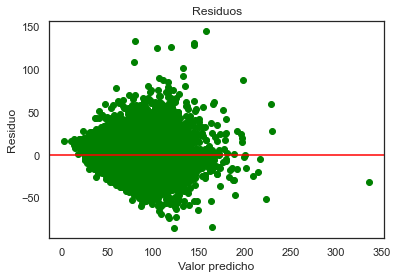

In [65]:
print('[INFO] Residuos del modelo')
plt.scatter(predictions_train, model.resid, color = 'green')
plt.axhline(y=0, color = 'red')
plt.title('Residuos')
plt.xlabel('Valor predicho')
plt.ylabel('Residuo')
plt.show()

### Utilizando Pycaret para POC de entrenamiento

In [66]:
#Separando dataset antes de ejecutar pycaret en entrenamiento, y entregable
print('[INFO]... Generando dataset training y entregable 🎨')
train_dataset = df_out[df_out['total_minutes'].isnull() == False]
entregable =  df_out[df_out['total_minutes'].isnull() == True]

[INFO]... Generando dataset training y entregable 🎨


In [68]:
print('[INFO]... Revisando tamaño dataset training y entregable 🧐')
print('Formato dataset entrenamiento: ', train_dataset.shape)
print('Formato dataset entregable: ', entregable.shape)

[INFO]... Revisando tamaño dataset training y entregable 🧐
Formato dataset entrenamiento:  (8000, 26)
Formato dataset entregable:  (2000, 26)


In [70]:
print('[INFO]... Generando listas para asignar tipo de variable en pycaret 🎯')
int_list = train_dataset.select_dtypes(include = [np.float, np.int]).columns.tolist()
cat_list = train_dataset.select_dtypes(include = [np.object]).columns.tolist()
int_list.remove('total_minutes')

[INFO]... Generando listas para asignar tipo de variable en pycaret 🎯


In [78]:
print('[INFO]... Configurando pycaret regressor 🎯')
model = setup(train_dataset, 
        target='total_minutes', 
        normalize = True,
        normalize_method = 'zscore',
        train_size = 0.80,
        categorical_features = cat_list,
        numeric_features = int_list,
        remove_outliers = True,
        outliers_threshold = 0.05,
        remove_multicollinearity = True,
        multicollinearity_threshold = 0.9,
        fold_shuffle = True,
        feature_selection = True,
        feature_selection_threshold = 0.8,
        session_id = 1992)

,Description,Value
0,session_id,1992
1,Target,total_minutes
2,Original Data,"(8000, 26)"
3,Missing Values,False
4,Numeric Features,20
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6080, 2593)"


In [79]:
print('[INFO]... Comparando modelos utilizando pycaret 🆚')
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,14.2698,371.0088,19.2490,0.6963,0.2303,0.1898,0.2300
gbr,Gradient Boosting Regressor,14.5207,384.2778,19.5889,0.6855,0.2365,0.1958,4.8250
lasso,Lasso Regression,14.7277,391.7807,19.7726,0.6797,0.2403,0.2003,0.1560
rf,Random Forest Regressor,14.6488,396.9068,19.9051,0.6754,0.2383,0.1961,5.8340
et,Extra Trees Regressor,14.6412,398.5669,19.9528,0.6738,0.2385,0.1943,9.7280
en,Elastic Net,15.7753,438.3902,20.9144,0.6420,0.2546,0.2197,0.1480
lar,Least Angle Regression,15.3996,443.5119,21.0435,0.6367,0.2516,0.2072,0.7470
br,Bayesian Ridge,13.1069,342.6730,17.5409,0.6227,0.2135,0.1763,11.1620
ridge,Ridge Regression,16.5253,492.8446,22.1855,0.5962,0.2775,0.2220,0.2920
knn,K Neighbors Regressor,17.1738,521.4473,22.8125,0.5742,0.2720,0.2285,2.8610


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=1992, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [80]:
print('[INFO]... Creacion del modelo con el mejor de todos 🚀')
model_run = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,13.5333,328.0151,18.1112,0.7058,0.2194,0.1798
1,14.1196,347.0953,18.6305,0.6953,0.2290,0.1884
2,14.4490,386.7090,19.6649,0.6555,0.2313,0.1919
3,14.0514,362.8475,19.0486,0.7117,0.2233,0.1805
4,15.3749,414.8630,20.3682,0.6800,0.2417,0.2021
5,13.9876,364.1786,19.0835,0.7060,0.2229,0.1847
6,15.3561,405.5957,20.1394,0.6829,0.2440,0.2103
7,14.1435,344.2437,18.5538,0.6811,0.2301,0.1909
8,13.7893,362.5761,19.0414,0.7287,0.2270,0.1801
9,13.8936,393.9643,19.8485,0.7158,0.2341,0.1890


In [81]:
# Parametros del modelo
print(model_run)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=1992, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [82]:
# Ajuste de hyperparametros
model_tuned = tune_model(model_run,
                        n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,13.4677,326.0424,18.0566,0.7075,0.2203,0.1800
1,14.0818,347.0843,18.6302,0.6953,0.2312,0.1910
2,14.5798,394.9165,19.8725,0.6482,0.2341,0.1938
3,13.7771,351.3900,18.7454,0.7208,0.2220,0.1787
4,15.1825,409.7752,20.2429,0.6840,0.2401,0.1990
5,14.1791,367.0286,19.1580,0.7037,0.2268,0.1891
6,15.4903,412.8257,20.3181,0.6772,0.2489,0.2146
7,14.4603,350.7922,18.7294,0.6750,0.2314,0.1950
8,14.3212,369.2237,19.2152,0.7238,0.2318,0.1889
9,14.5356,417.2872,20.4276,0.6990,0.2396,0.1970


In [83]:
# Evaluar modelo
evaluate_model(model_tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

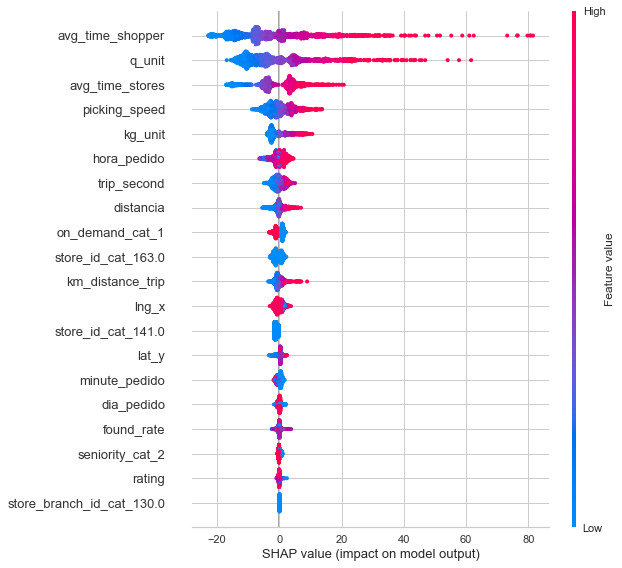

In [85]:
#Interpretacion del modelo
interpret_model(model_tuned)

In [92]:
#Guardar modelo
save_model(model_tuned, 'conershop_order_time')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['on_demand_cat',
                                                             'shopper_id_cat',
                                                             'store_branch_id_cat',
                                                             'store_id_cat',
                                                             'seniority_cat'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['lat_x', 'lng_x',
                                                           'found_rate',
                                                           'picking_speed',
                                                           'accepted_rate',
                                                           'rating', 'q_unit',
             

In [87]:
#Generar predicciones
predictions = predict_model(model_tuned, data = entregable )
#predictions = model_tuned.predict(entregable)

In [89]:
#Generar predicciones
predictions['Label'].head()

order_id
3a226ea48debc0a7ae9950d5540f2f34    76.264767
9bf29b56619fcaf60b52690a848e10bb    85.049074
299d948a5fd2cf2a921894b9bd24b94e    97.129112
150bd9290b2125e67541098173e2cfb1    94.553256
844f746ff505c01c088de90bce067b94    61.173409
Name: Label, dtype: float64

In [101]:
#Guardando predicciones
predictions['Label'].to_csv('./data/predictions.csv')